# TP1: FEATURE EXTRACTION & VISUALIZATION

---



In this notebook, you will learn how to **extract radiomics features** and **visualize the important characteristics of the dataset**. We follow a typical data analysis pipeline.

<img src='https://raw.githubusercontent.com/RRouhi/EPU-IA-2022/main/images/pipeline.png'/>

First, download the necessary materials for the practical sessions.

In [ ]:
!git clone https://github.com/marsvn/PythonM2-jour3.git
%cd PythonM2-jour3/

Cloning into 'PythonM2-jour3'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 173 (delta 6), reused 5 (delta 2), pack-reused 157 (from 1)
Receiving objects: 100% (173/173), 165.20 MiB | 30.79 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (130/130), done.
/content/PythonM2-jour3/PythonM2-jour3


### Installation of dependencies

In [ ]:
!pip install pyradiomics SimpleITK

## 1. Loading data

The dataset we will work on is a subset of the BraTS dataset (https://www.med.upenn.edu/cbica/brats2019/data.html). There are 10 patients in each of the Glioblastoma (`./data/preprocessed/GBM`) and Low-Grade Glioma (`./data/preprocessed/LGG`) classes. Each patient has five files: four MRI volumes of the brain under T1, T1-Gd, T2, and T2 Flair imaging modalities; and a tumour segmentation file. Let us start by considering **a single patient**:

In [ ]:
import os

root_dir = './data/preprocessed'

patient = 'GBM/TCGA-02-0037'
patient_dir = os.path.join(root_dir, patient)
patient_files = os.listdir(patient_dir)

print(patient_files)

['TCGA-02-0037_1998.01.13_t1ce.nii.gz', 'TCGA-02-0037_1998.01.13_flair.nii.gz', 'TCGA-02-0037_1998.01.13_t1.nii.gz', 'TCGA-02-0037_1998.01.13_seg.nii.gz', 'TCGA-02-0037_1998.01.13_t2.nii.gz']


We will now visualise the files of this patient. In the following, the data is returned in the `sitk` format. `SimpleITK` is a python library for registration and segmentation of biomedical images. Two test cases will be loaded and and saved.

In [ ]:
import glob
import matplotlib.pyplot as plt
import SimpleITK as sitk

def load_nii_volume_as_array(filename, with_header=False):
    """
    load NIfTI image into numpy array with axis order of [z,y,x]
    The output array shape is like [Depth, Height, Width]
    :param filename: the input file name, should be *.nii or *.nii.gz
    :param with_header: return header information
    :return: a numpy data array or numpy data array with header if set to True
    """
    img = sitk.ReadImage(filename)
    data = sitk.GetArrayFromImage(img)

    if with_header:
        origin, spacing, direction = img.GetOrigin(), img.GetSpacing(), img.GetDirection()
        return data, (origin, spacing, direction)
    else:
        return data

volume = load_nii_volume_as_array(os.path.join(patient_dir, patient_files[0]))
print(volume.shape)

(155, 240, 240)


There are $155$ slices in the volume, where each slice is $240\times240$px image. Let's visualise some of them.

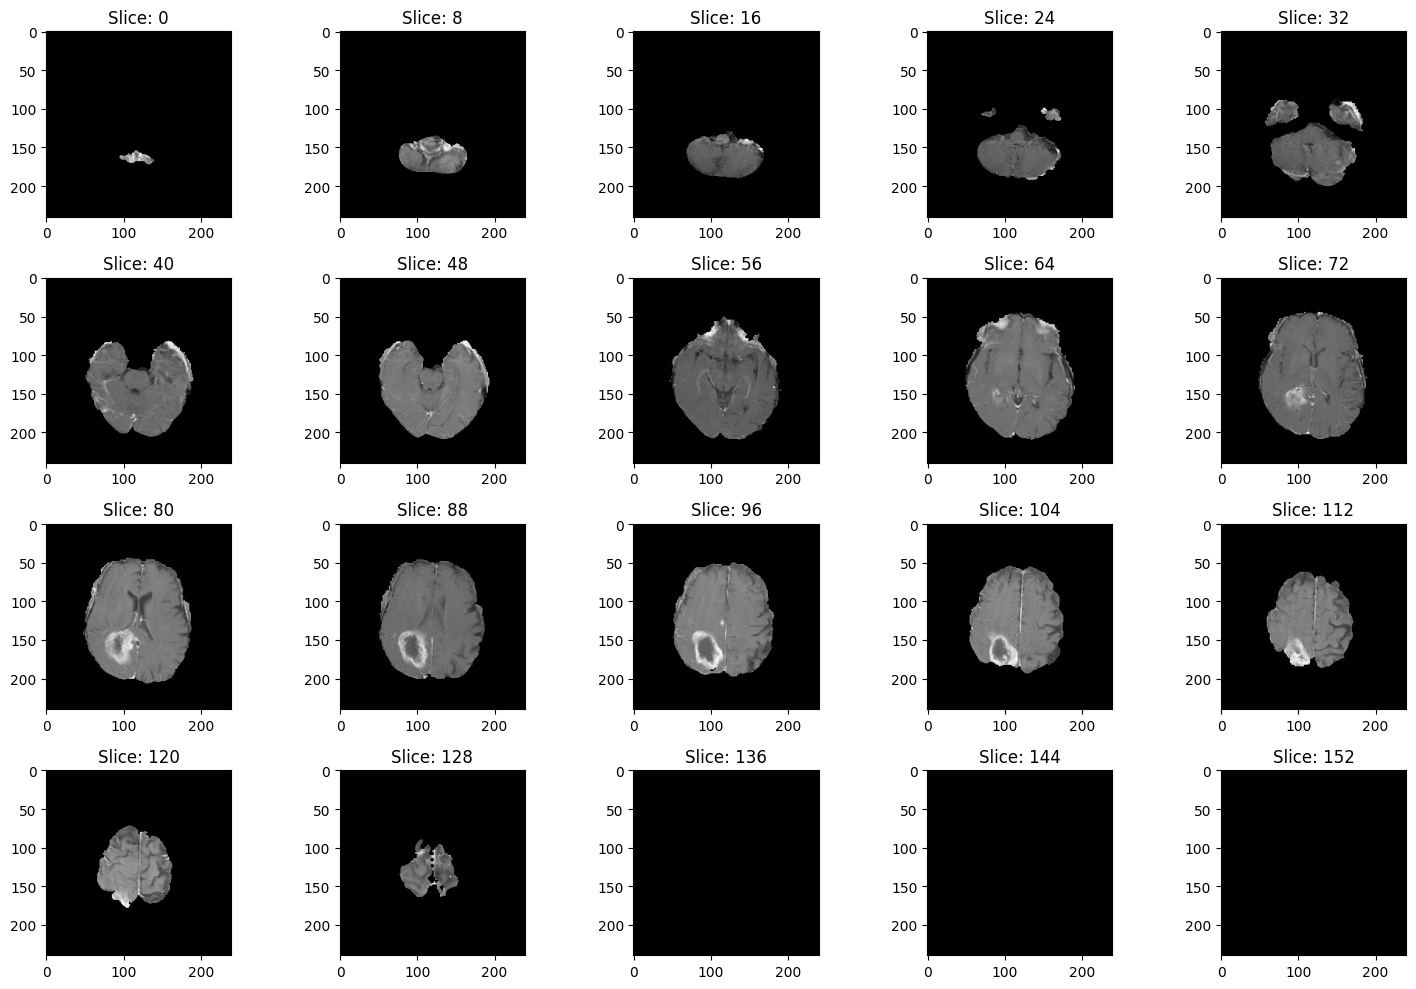

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(15, 10))
for i, img in enumerate(volume[::8]):
    axes.ravel()[i].set_title('Slice: %d' % (8 * i))
    axes.ravel()[i].imshow(img, cmap='Greys_r')

plt.tight_layout()

### Solution 1

 we visualise a single slice for each imaging modality and the tumour segmentation mask:

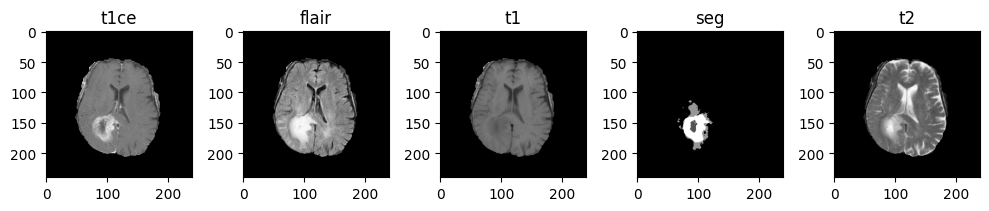

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(10, 10))

for i, patient_file in enumerate(patient_files):
    volume = load_nii_volume_as_array(os.path.join(patient_dir, patient_file))
    axes[i].imshow(volume[80], cmap='Greys_r')
    axes[i].set_title(patient_file.split('_')[-1].split('.')[0])

plt.tight_layout()

## 2. Normalising data

To stabilise the downstream feature extraction and analysis, we first normalise the data. For input image $X$, we create normalised image $Z$ by normalising each pixel $x_{ij}$ according to,

$$z_{ij} = \frac{x_{ij} - \mu_X}{\sigma_X}.$$

Because of the abundance of background values in each volume, we compute $\mu_X$ and $\sigma_X$ only over the pixels of $X$ above a certain threshold.

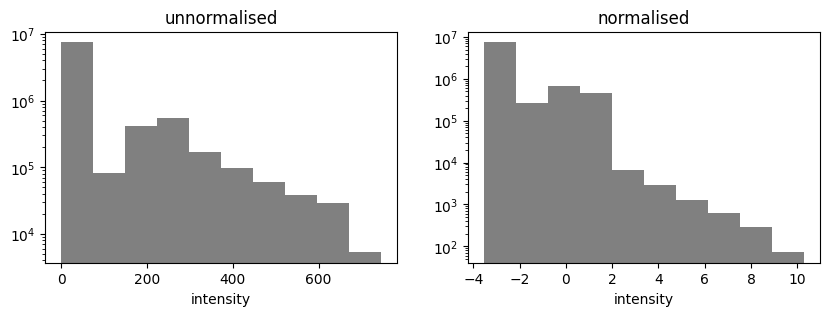

In [ ]:
from glob import glob


def set_header_information(array, header):
    """
    Function to set header information to an array.
    :param array: array to set the header
    :param header: header information will be a tuple with (origin, spacing, direction)
    :return: an image in sitk format
    """
    img = sitk.GetImageFromArray(array)
    img.SetOrigin(header[0])
    img.SetSpacing(header[1])
    img.SetDirection(header[2])
    return img

def zscore_normalize(patient, image_type):
    """
    Function to Z-Score normalize an image from an image filepath. It will normalize the target
    image by subtracting the mean of the whole brain and dividing by the standard deviation.
    :param img_path: target MR brain image path
    :param mask: brain mask path for img
    :return: Normalized image in sitk format
    """

    img_path = glob(os.path.join(root_dir, patient, f'*{image_type}.nii.gz'))[0]
    img_data, header = load_nii_volume_as_array(img_path, with_header=True)
    mask = (img_data > img_data.mean()) == 1  # force the mask to be logical type

    mean = img_data[mask].mean()
    std = img_data[mask].std()

    normalized_data = (img_data - mean) / std
    normalized = set_header_information(normalized_data, header)

    return normalized

normalised_image = zscore_normalize(patient, 't1')
normalised_volume = sitk.GetArrayFromImage(normalised_image)

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

def plot_histogram(ax, volume, title):
    ax.hist(volume.flatten(), color='gray')
    ax.set_xlabel('intensity')
    ax.set_yscale('log')
    ax.set_title(title)

plot_histogram(axes[0], volume, 'unnormalised')
plot_histogram(axes[1], normalised_volume, 'normalised')

### Extract mask information

If we visualise a given slice of any mask volume, we see that it is in fact a multi-class image, where different values indicate different tumour regions: enhancing tumour (ET), peritumoral edema (ED), necrosis.

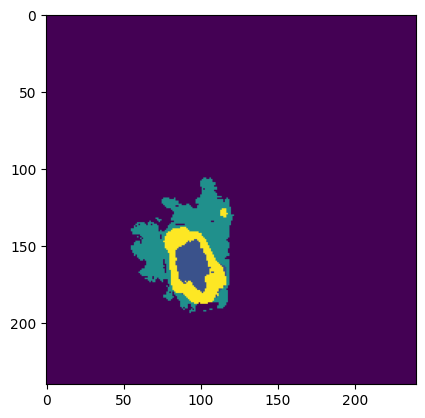

In [ ]:
mask_path = glob(os.path.join(root_dir, patient, '*seg*'))[0]
mask, header = load_nii_volume_as_array(mask_path, with_header=True)

plt.imshow(mask[96])

From this multi-class mask, we can derive the regions as separate binary masks. We define a special purpose function to extract each mask region as a separate binary mask.

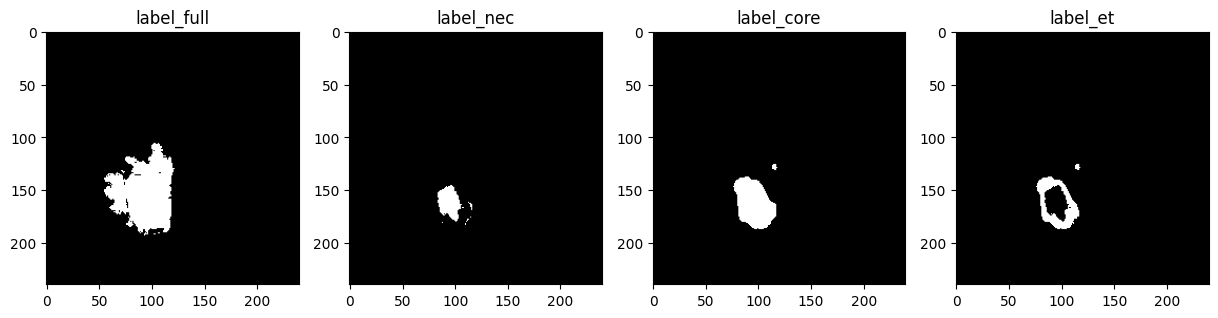

In [ ]:
def get_masks(patient):
    """
    Function to read one subject's mask from the general input directory specified by patient ID
    :param patient: the patient ID
    :return: a dict for the 'seg' with key as type of seg and value as nD array. For image a nD array
    """

    mask_path = glob(os.path.join(root_dir, patient, '*seg*'))[0]
    mask, header = load_nii_volume_as_array(mask_path, with_header=True)

    label_full = mask.copy()
    label_full[mask != 0] = 1        # take all regions

    label_nec = mask.copy()
    label_nec[mask != 1] = 0         # necrosis only

    label_core = mask.copy()
    label_core[mask == 2] = 0        # no edema
    label_core[label_core != 0] = 1  # keep necrosis, ET, NET i.e. tumor core

    label_et = mask.copy()
    label_et[mask != 4] = 0          # ET only
    label_et[mask == 4] = 1

    all_masks = {
        'label_full' : set_header_information(label_full, header),
        'label_nec' : set_header_information(label_nec, header),
        'label_core' : set_header_information(label_core, header),
        'label_et' : set_header_information(label_et, header)
    }

    return all_masks

all_masks = get_masks(patient)

fig, axes = plt.subplots(ncols=4, figsize=(15, 5))

for ax, mask_key, mask_volume in zip(axes, all_masks.keys(), all_masks.values()):
    ax.set_title(mask_key)
    ax.imshow(sitk.GetArrayFromImage(mask_volume)[96], cmap='Greys_r')

**Exercise:** Replace the expression `CompleteHere` in the following script to:
- load images and segmentations from the two patients
- apply normalisation to MRI images
- save the normalised images

In [ ]:
#@title Solution 2


"""
>>> Preprocess patient 1
"""

patient1 = 'GBM/TCGA-02-0037/'

# normalise volumes
patient1_t1 = zscore_normalize(patient1, 't1')
patient1_t1ce = zscore_normalize(patient1, 't1ce')
patient1_t2 = zscore_normalize(patient1, 't2')
patient1_flair = zscore_normalize(patient1, 'flair')

# Write normalised volumes
sitk.WriteImage(patient1_t1, 'patient1_t1_normalize.nii.gz')
sitk.WriteImage(patient1_t1ce, 'patient1_t1ce_normalize.nii.gz')
sitk.WriteImage(patient1_t2, 'patient1_t2_normalize.nii.gz')
sitk.WriteImage(patient1_flair, 'patient1_flair_normalize.nii.gz')

# Derive masks
patient1_masks = get_masks(patient1)

# Write masks
sitk.WriteImage(patient1_masks['label_full'], 'patient1_seg_label_full.nii.gz')
sitk.WriteImage(patient1_masks['label_nec'], 'patient1_seg_label_nec.nii.gz')
sitk.WriteImage(patient1_masks['label_core'], 'patient1_seg_label_core.nii.gz')
sitk.WriteImage(patient1_masks['label_et'], 'patient1_seg_label_et.nii.gz')

"""
>>> Preprocess patient 2
"""

patient2 = 'LGG/TCGA-CS-5396/'

# Normalise volumes
patient2_t1 = zscore_normalize(patient2, 't1')
patient2_t1ce = zscore_normalize(patient2, 't1ce')
patient2_t2 = zscore_normalize(patient2, 't2')
patient2_flair = zscore_normalize(patient2, 'flair')

# Write normalised volumes
sitk.WriteImage(patient2_t1, 'patient2_t1_normalize.nii.gz')
sitk.WriteImage(patient2_t1ce, 'patient2_t1ce_normalize.nii.gz')
sitk.WriteImage(patient2_t2, 'patient2_t2_normalize.nii.gz')
sitk.WriteImage(patient2_flair, 'patient2_flair_normalize.nii.gz')

# Derive masks
patient2_masks = get_masks(patient2)

# Write masks
sitk.WriteImage(patient2_masks['label_full'], 'patient2_seg_label_full.nii.gz')
sitk.WriteImage(patient2_masks['label_nec'], 'patient2_seg_label_nec.nii.gz')
sitk.WriteImage(patient2_masks['label_core'], 'patient2_seg_label_core.nii.gz')
sitk.WriteImage(patient2_masks['label_et'], 'patient2_seg_label_et.nii.gz')

## 3. Feature extraction

Now that we have prepared our image inputs, we need to define the parameters and instantiate the extractor. We use the default settings of the extractor. Let us extract features for patient 1, under the t1 modality, for the full tumour region.

In [ ]:
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

imagePath = 'patient1_t1_normalize.nii.gz'
maskPath = 'patient1_seg_label_full.nii.gz'

result = extractor.execute(imagePath, maskPath)
print(result.values())

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firsto

odict_values(['v3.0.1', '1.26.4', '2.4.1', '1.8.0', '3.11.11', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}, {'Original': {}}, '493eb421094d9b8bc64bd556d018f5a686d3f772', '3D', (1.0, 1.0, 1.0), (240, 240, 155), -2.9693460335554422, -3.5522976042373386, 10.296317619461057, 'b7b0de57fd41692f17e188c12b0c3aaa84804f79', (1.0, 1.0, 1.0), (240, 240, 155), (54, 100, 57, 71, 97, 72), 125370, 10, (94.14335965541996, 153.86679428890483, 92.94260987477068), (94.14335965541996, -85.13320571109517, 92.94260987477068), 0.8179343476569421, 0.7413062873194535, 52.14478465024866, 70.34175420095654, array(75.3923073), array(95.52486587), array(96.5194281), array(98.72183143), array(125154.79166667), 57.53493683540435, ar

As you can see, Pyradiomics returns an ordered dictionary that is visually not very pleasant. We can instead turn this result into a `pandas` format. The keys in the dictionary will be used as the index (labels for the rows), with the values of the features as the values in the rows.

In [ ]:
import pandas as pd

df = pd.Series(result)
print(df)

diagnostics_Versions_PyRadiomics                    v3.0.1
diagnostics_Versions_Numpy                          1.26.4
diagnostics_Versions_SimpleITK                       2.4.1
diagnostics_Versions_PyWavelet                       1.8.0
diagnostics_Versions_Python                        3.11.11
                                             ...          
original_ngtdm_Busyness                  761.1415643669351
original_ngtdm_Coarseness           0.00039995609234343035
original_ngtdm_Complexity              0.03988632771763625
original_ngtdm_Contrast               0.004254314947146588
original_ngtdm_Strength              0.0003936474288322534
Length: 129, dtype: object


### Process all

Now we will use a loop to extract a set of features for our two patients with each of their segmentations. The idea is to loop over each image the associated segmentations. We construct a `pandas.DataFrame` object to list each combination.

In [ ]:
image_names = sorted(glob('patient1*normalize*'))
mask_names = sorted(glob('patient1_seg*'))

index = pd.MultiIndex.from_product([image_names, mask_names], names = ['Image', 'Segmentation'])
df_patient1 = pd.DataFrame(index=index).reset_index()

image_names = sorted(glob('patient2*normalize*'))
mask_names = sorted(glob('patient2_seg*'))

index = pd.MultiIndex.from_product([image_names, mask_names], names = ['Image', 'Segmentation'])
df_patient2 = pd.DataFrame(index=index).reset_index()

database_df = pd.concat([df_patient1, df_patient2]).reset_index(drop=True)
database_df

,Image,Segmentation
0,patient1_flair_normalize.nii.gz,patient1_seg_label_core.nii.gz
1,patient1_flair_normalize.nii.gz,patient1_seg_label_et.nii.gz
2,patient1_flair_normalize.nii.gz,patient1_seg_label_full.nii.gz
3,patient1_flair_normalize.nii.gz,patient1_seg_label_nec.nii.gz
4,patient1_t1_normalize.nii.gz,patient1_seg_label_core.nii.gz
5,patient1_t1_normalize.nii.gz,patient1_seg_label_et.nii.gz
6,patient1_t1_normalize.nii.gz,patient1_seg_label_full.nii.gz
7,patient1_t1_normalize.nii.gz,patient1_seg_label_nec.nii.gz
8,patient1_t1ce_normalize.nii.gz,patient1_seg_label_core.nii.gz
9,patient1_t1ce_normalize.nii.gz,patient1_seg_label_et.nii.gz


Now we can iterate over each row of our `pandas.DataFrame` and extract features for each combination of modality and tumour interest region.

In [ ]:
from radiomics import featureextractor

paramPath = os.path.join('exampleSettings', 'Params.yaml')
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

results_extraction = pd.DataFrame()
for row_idx, row in database_df.iterrows():
    print('process:'  '   ----   ' 'Image: ', row['Image'], ' Segmentation: ', row['Segmentation'])
    result_extraction = pd.Series(extractor.execute(row['Image'], row['Segmentation']))
    feature_vector = pd.concat([pd.Series(row), result_extraction])
    feature_vector.name = row_idx
    results_extraction = results_extraction.join(feature_vector, how='outer')

# Transpose DataFrame to have one row per analysis
results_extraction = results_extraction.T

INFO:radiomics.featureextractor:Loading parameter file exampleSettings/Params.yaml
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_flair_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t1ce_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient1_t2_normalize.nii.gz  Segmentation:  patient1_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_flair_normalize.nii.gz  Segmentation:  patient2_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_flair_normalize.nii.gz  Segmentation:  patient2_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_flair_normalize.nii.gz  Segmentation:  patient2_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_flair_normalize.nii.gz  Segmentation:  patient2_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1_normalize.nii.gz  Segmentation:  patient2_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1_normalize.nii.gz  Segmentation:  patient2_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1_normalize.nii.gz  Segmentation:  patient2_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1_normalize.nii.gz  Segmentation:  patient2_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1ce_normalize.nii.gz  Segmentation:  patient2_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1ce_normalize.nii.gz  Segmentation:  patient2_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1ce_normalize.nii.gz  Segmentation:  patient2_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t1ce_normalize.nii.gz  Segmentation:  patient2_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t2_normalize.nii.gz  Segmentation:  patient2_seg_label_core.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t2_normalize.nii.gz  Segmentation:  patient2_seg_label_et.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t2_normalize.nii.gz  Segmentation:  patient2_seg_label_full.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


process:   ----   Image:  patient2_t2_normalize.nii.gz  Segmentation:  patient2_seg_label_nec.nii.gz


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm


The result consists of a table where each row corresponds to an modality/interest region pair, and each column is a radiomics feature. We can print a few rows using `pd.DataFrame.head()`:

In [ ]:
results_extraction.head()

,Image,Segmentation,diagnostics_Configuration_EnabledImageTypes,diagnostics_Configuration_Settings,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Hash,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Size,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,patient1_flair_normalize.nii.gz,patient1_seg_label_core.nii.gz,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,80c00b8ff944bef2b799deee37bd5fc563349b82,6.826994,-2.402958,-2.867947,"(240, 240, 155)",...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,56478.375,43.414003,0.6680065436468083,10656.75225427656,0.18868730295934613,56563.0
1,patient1_flair_normalize.nii.gz,patient1_seg_label_et.nii.gz,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,80c00b8ff944bef2b799deee37bd5fc563349b82,6.826994,-2.402958,-2.867947,"(240, 240, 155)",...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,43357.083333333336,46.692448,0.400177592069103,14914.3637359928,0.34398909219353546,43375.0
2,patient1_flair_normalize.nii.gz,patient1_seg_label_full.nii.gz,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,80c00b8ff944bef2b799deee37bd5fc563349b82,6.826994,-2.402958,-2.867947,"(240, 240, 155)",...,75.39230729988306,95.524865872714,96.51942809610924,98.72183142547549,125154.79166666667,57.534937,0.3746906639575588,32293.087811030357,0.258025181305393,125370.0
3,patient1_flair_normalize.nii.gz,patient1_seg_label_nec.nii.gz,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,80c00b8ff944bef2b799deee37bd5fc563349b82,6.826994,-2.402958,-2.867947,"(240, 240, 155)",...,51.24451190127583,50.15974481593781,51.42956348249516,58.35237784358063,13007.833333333334,28.848118,0.5184839176448882,5158.841011256494,0.3965949500626413,13188.0
4,patient1_t1_normalize.nii.gz,patient1_seg_label_core.nii.gz,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,493eb421094d9b8bc64bd556d018f5a686d3f772,10.296318,-2.969346,-3.552298,"(240, 240, 155)",...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,56478.375,43.414003,0.6680065436468083,10656.75225427656,0.18868730295934613,56563.0


### Compare feature signatures

Now, let's compare the feature "signatures" for our two patients. Because we would like to plot the feature vectors, we will create `numpy` arrays for those features with prefix `original_` (i.e. excluding meta-features). We begin by extracting the relevant parts of `results_extraction` above.

In [ ]:
# Extract patient and modality identifiers
patient = results_extraction['Image'].str.split('_').str[0]
sequence = results_extraction['Image'].str.split('_').str[1]

# Extract segmentation type
segtype = results_extraction['Segmentation'].str.split('_').str[-1].str.split('.').str[0]

# Extract non-meta features
feature_columns = [col for col in results_extraction if col.startswith('original')]

dataframe_cleaned = results_extraction[feature_columns]
dataframe_cleaned.insert(0, 'patient', patient)
dataframe_cleaned.insert(1, 'sequence', sequence)
dataframe_cleaned.insert(2, 'segmentation', segtype)

dataframe_cleaned.head()

,patient,sequence,segmentation,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,patient1,flair,core,1.4463015221940736,3.5307137687632646,437410.2004467405,0.013907546100175326,1.0906808266931813,3.1082402864601804,5.057666926133718,...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,56478.375,43.414003,0.6680065436468083,10656.75225427656,0.18868730295934613,56563.0
1,patient1,flair,et,1.3008774119683162,3.5307137687632646,318888.7266704072,0.017508710733841398,1.260342288623232,2.685059520281039,5.057666926133718,...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,43357.083333333336,46.692448,0.400177592069103,14914.3637359928,0.34398909219353546,43375.0
2,patient1,flair,full,0.7191809710652861,3.3125776034246286,521828.9683033464,0.01271732294122169,1.7935640261176757,1.8897540676210756,5.057666926133718,...,75.39230729988306,95.524865872714,96.51942809610924,98.72183142547549,125154.79166666667,57.534937,0.3746906639575588,32293.087811030357,0.258025181305393,125370.0
3,patient1,flair,nec,2.2703714801400325,3.5549511204675577,118521.47377633328,-3.203426503814917e-16,0.678645847720202,3.3421935322691554,4.257834319892052,...,51.24451190127583,50.15974481593781,51.42956348249516,58.35237784358063,13007.833333333334,28.848118,0.5184839176448882,5158.841011256494,0.3965949500626413,13188.0
4,patient1,t1,core,-0.3941377910280705,0.7205068489281418,12782.888373385857,0.8088946802685385,0.506656654525551,2.7226469217701093,1.3960490549622098,...,58.82176467941097,62.42595614005443,66.09841147864296,69.03622237637282,56478.375,43.414003,0.6680065436468083,10656.75225427656,0.18868730295934613,56563.0


We can now extract the feature signatures for a given modality/region combination by slicing `dataframe_cleaned`:

**Exercise:** Complete the following script to:
- plot the two feature vectors and their difference.

Notes:
- Feature values have a wide range of magnitudes and will be plotted on a log scale. You can have fun and change the input modality or the segmentation type.
- plot will be composed of three subplot, first is features from patient1 from a modality_type1 for segtype1. Second is features from patient2 from a modality_type2 for segtype2. Third subplot is the difference between the two features vectors.

<ipython-input-44-76178c85723a>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(feature_columns, rotation='vertical')


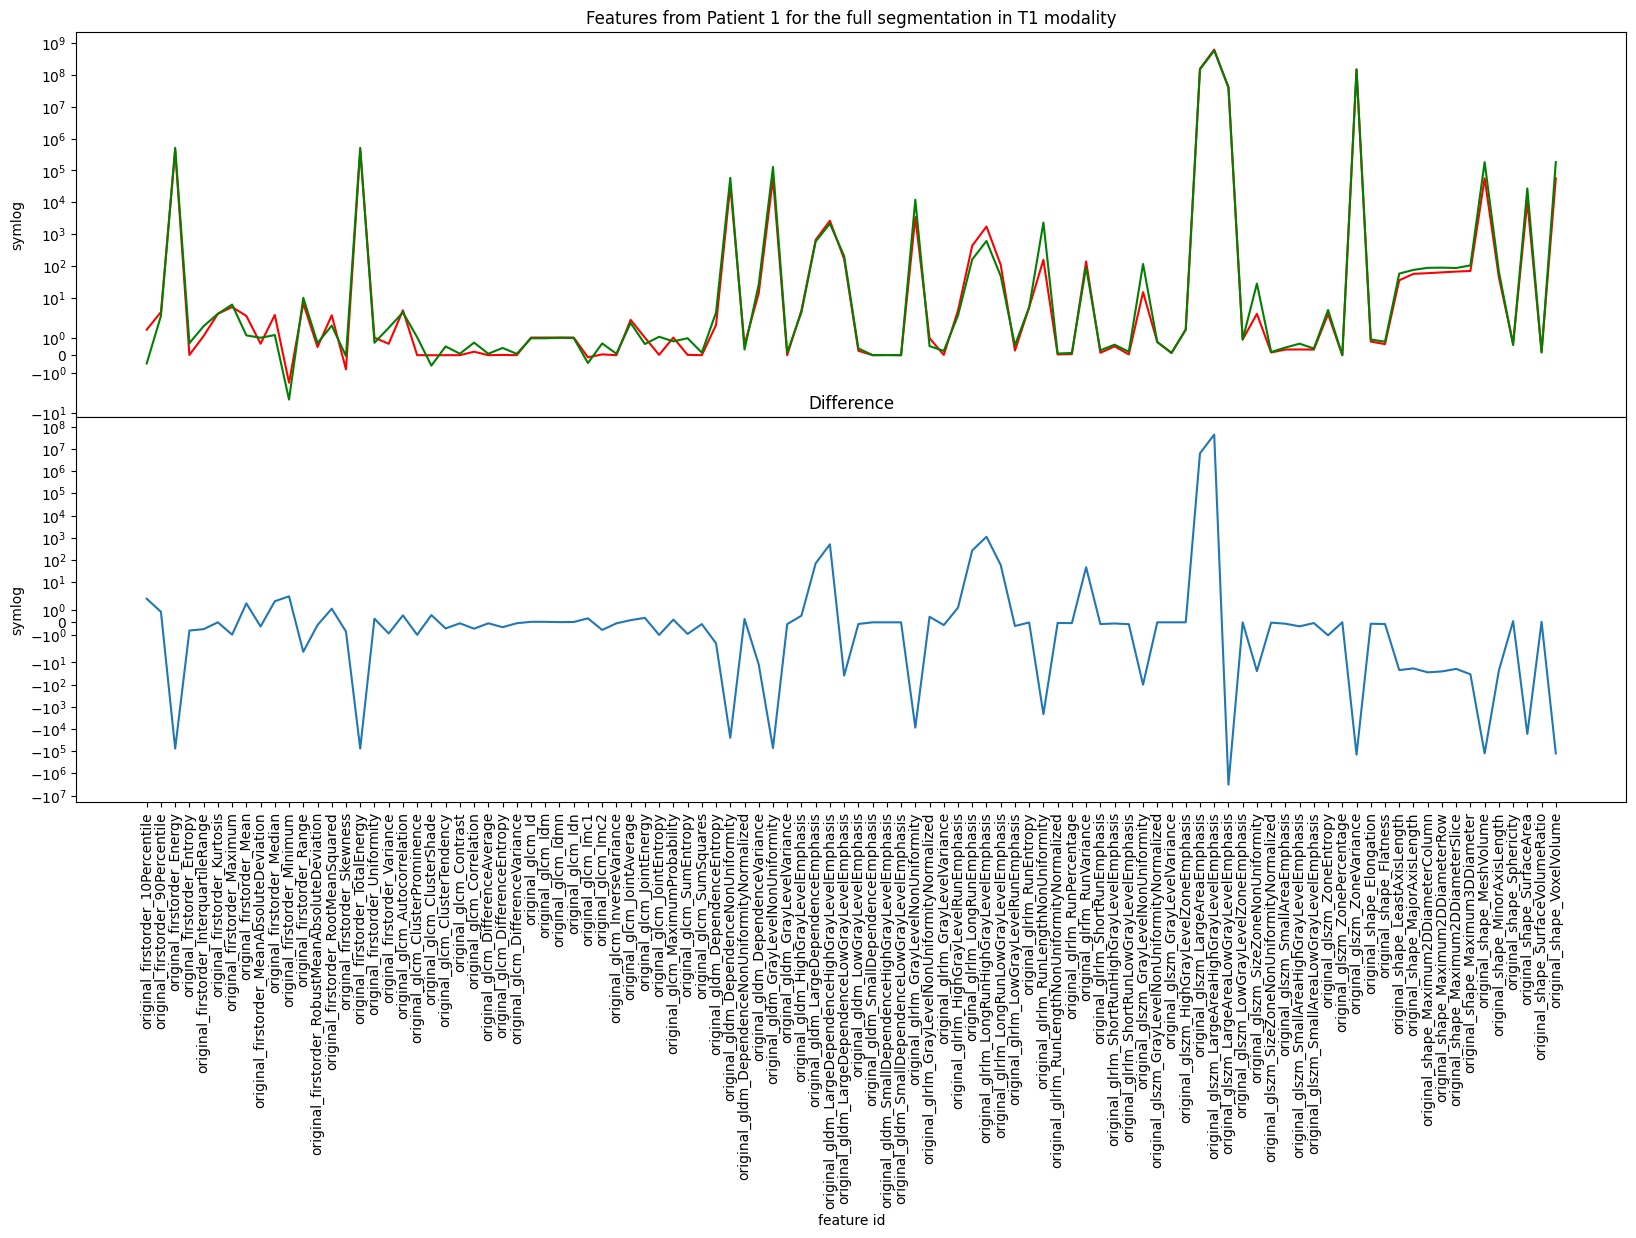

In [ ]:
#@title Solution 3

modality = 't1ce'
seg = 'core'

features_p1 =  dataframe_cleaned.iloc[0, 3:].to_numpy()
features_p2 =  dataframe_cleaned.iloc[16, 3:].to_numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True, figsize=(20, 10))

axes[0].plot(features_p1, label=f"features from patient 1 for the segmentation {seg} in modality {modality}", color='red')
axes[0].plot(features_p2, label=f"features from patient 2 for the segmentation {seg} in modality {modality}", color='green')
axes[0].set_yscale('symlog')
axes[0].set_ylabel('symlog')
axes[0].set_xlabel('feature id')
axes[0].set_xticklabels(feature_columns, rotation='vertical')
axes[0].legend()

axes[1].plot(features_p1 - features_p2)
axes[1].set_yscale('symlog')
axes[1].set_ylabel('symlog')
axes[1].set_xlabel('feature id')
axes[1].set_xticks(range(len(features_p1)))
axes[1].set_xticklabels(feature_columns, rotation=90)
axes[1].set_title("Difference")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show();

## 4. Exploring and Visualizing Data

The first step in applying machine learning is to understand the data, so as to be able to identify a good target to learn, as well as an appropriate learning algorithm among many alternatives.

The analysis above has been applied on two patients only. Since our time in this practical session is limited, the features on the entire BraTS dataset has been extracted into a csv file located at `./data/radiomics_analysis_cleaned.csv`. This file contains one row per patient per input modality (T1, T1ce, T2, flair) per type of tumor ROI ($4\times4=16$ rows per patient). With the feaures from the full cohort, we can begin to explore the data.

In [ ]:
import pandas as pd
from IPython.display import display

path_dataset = './data/radiomics_analysis_cleaned.csv'

data = pd.read_csv(path_dataset)
data.head(10)

,patient,sequence,segmentation,label,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,TCGA-02-0003,flair,core,HGG,188.897385,574.352612,6.064746e+09,4.685465,145.083069,5.108184,...,52.478567,66.219333,54.817880,67.119297,14092.041667,38.721856,0.472503,5971.201612,0.423729,14159.0
1,TCGA-02-0003,flair,et,HGG,185.315094,455.778564,4.843681e+09,4.417837,111.051224,7.267727,...,50.477718,66.219333,54.817880,67.119297,12658.583333,39.482731,0.362798,7240.066708,0.571949,12695.0
2,TCGA-02-0003,flair,full,HGG,144.118668,373.385712,2.470281e+10,4.211199,116.424683,9.437376,...,76.537572,116.709040,104.235311,120.718681,78659.125000,52.041219,0.478543,18552.213339,0.235856,78933.0
3,TCGA-02-0003,flair,nec,HGG,255.169891,822.964111,1.221065e+09,5.193230,263.298859,2.593050,...,49.678969,58.694122,42.059482,62.040309,1384.208333,27.458949,0.346139,1735.275848,1.253623,1464.0
4,TCGA-02-0003,t1,core,HGG,-50.766136,99.490303,1.526464e+09,3.602474,84.024981,5.841316,...,52.478567,66.219333,54.817880,67.119297,14092.041667,38.721856,0.472503,5971.201612,0.423729,14159.0
5,TCGA-02-0003,t1,et,HGG,-50.766136,87.232539,1.323440e+09,3.503855,80.070864,6.735606,...,50.477718,66.219333,54.817880,67.119297,12658.583333,39.482731,0.362798,7240.066708,0.571949,12695.0
6,TCGA-02-0003,t1,full,HGG,-37.915257,95.536186,9.386010e+09,3.586215,71.174101,11.850495,...,76.537572,116.709040,104.235311,120.718681,78659.125000,52.041219,0.478543,18552.213339,0.235856,78933.0
7,TCGA-02-0003,t1,nec,HGG,-44.834961,156.824997,2.030243e+08,3.752487,72.162636,4.072064,...,49.678969,58.694122,42.059482,62.040309,1384.208333,27.458949,0.346139,1735.275848,1.253623,1464.0
8,TCGA-02-0003,t1ce,core,HGG,129.697449,400.642712,4.555342e+09,4.401046,146.813309,2.588113,...,52.478567,66.219333,54.817880,67.119297,14092.041667,38.721856,0.472503,5971.201612,0.423729,14159.0
9,TCGA-02-0003,t1ce,et,HGG,134.093048,404.862488,4.141220e+09,4.375482,148.571548,2.463108,...,50.477718,66.219333,54.817880,67.119297,12658.583333,39.482731,0.362798,7240.066708,0.571949,12695.0


We can generate a full `pandas.DataFrame` which represents all the features for a patient. This gives $16\times100 = 1600$ featues per patient.

In [ ]:
full_features_df = data.pivot_table(index=['patient', 'label'],
                                    columns=['sequence', 'segmentation'],
                                    values=data.columns[4:])
full_features_df.columns = ['_'.join(col).strip() for col in full_features_df.columns.values]
full_features_df.reset_index(level=1, inplace=True)

label_counts = full_features_df['label'].value_counts()

print('Patients per disease class: %d HGG, %d LGG' % (label_counts.HGG, label_counts.LGG))
print('Numbers of features: %d' % (len(full_features_df.columns) -1))

Patients per disease class: 135 HGG, 108 LGG
Numbers of features: 1600


### Pairwise joint distributions

We can see the join distribution of any pair of columns/attributes/variables/features by using the pairplot function offered by `Seaborn`, which is a plotting library based on `Matplotlib`. We do this for the first 5 features. Each datapoint is a patient and the colour indicates the disease class.

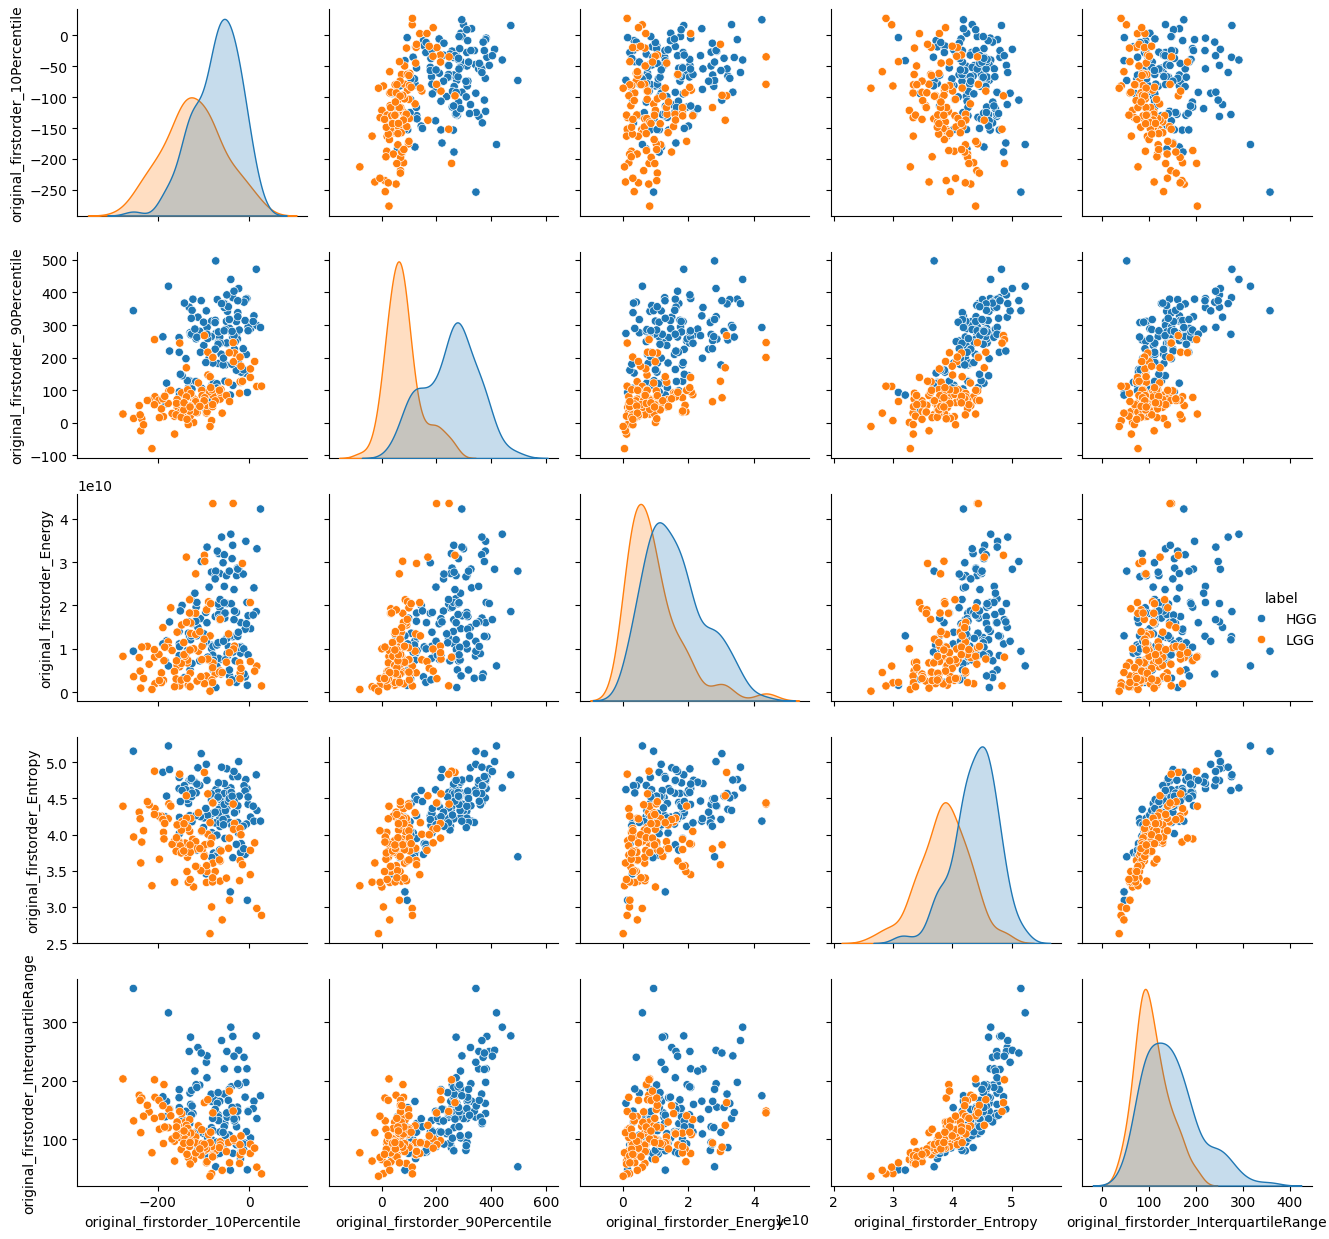

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter one sequence type and a segmentation type (you can change the sequence type and segmentation type)
d = data[(data['sequence']=='t1ce')  & (data['segmentation']=='full')].iloc[:, 3:9]

sns.pairplot(d, hue='label', height=2.5)
plt.tight_layout()
plt.show()

### Solution 4: Interpretation

We can observe in the plots that some pairs of features yield a high degree of discrimination between LGG (in orange) and HGG (in blue) patients.
For instance, the plot in the second row, first column, between the features 10Percentile (10th percentile of image intensities) and 90Percentile (idem with 90th) appears to cluster each cancer subtypes into roughly distinct clusters.

In these 2D feature subspaces, a simple line separating the two classes would form the basis of a decision system for classifying an MRI. Multi-dimensional models, applied on many hundreds of features, essentially perform the same method, by fitting a *hyperplane* such to best separate the datapoints from each class.

### Plot features' dependency as a heatmap

Plotting all pairwise distributions may still be hard to interpret when we have a lot of variables in the dataset. Instead, we can just plot the correlation matrix to quantify the linear relationship between variables.

A heat map uses colour to depict the correlation of each feature with every other feature. A heatmap may furthremore be clustered (unsupervised machine learning) to show groupings of similar features.

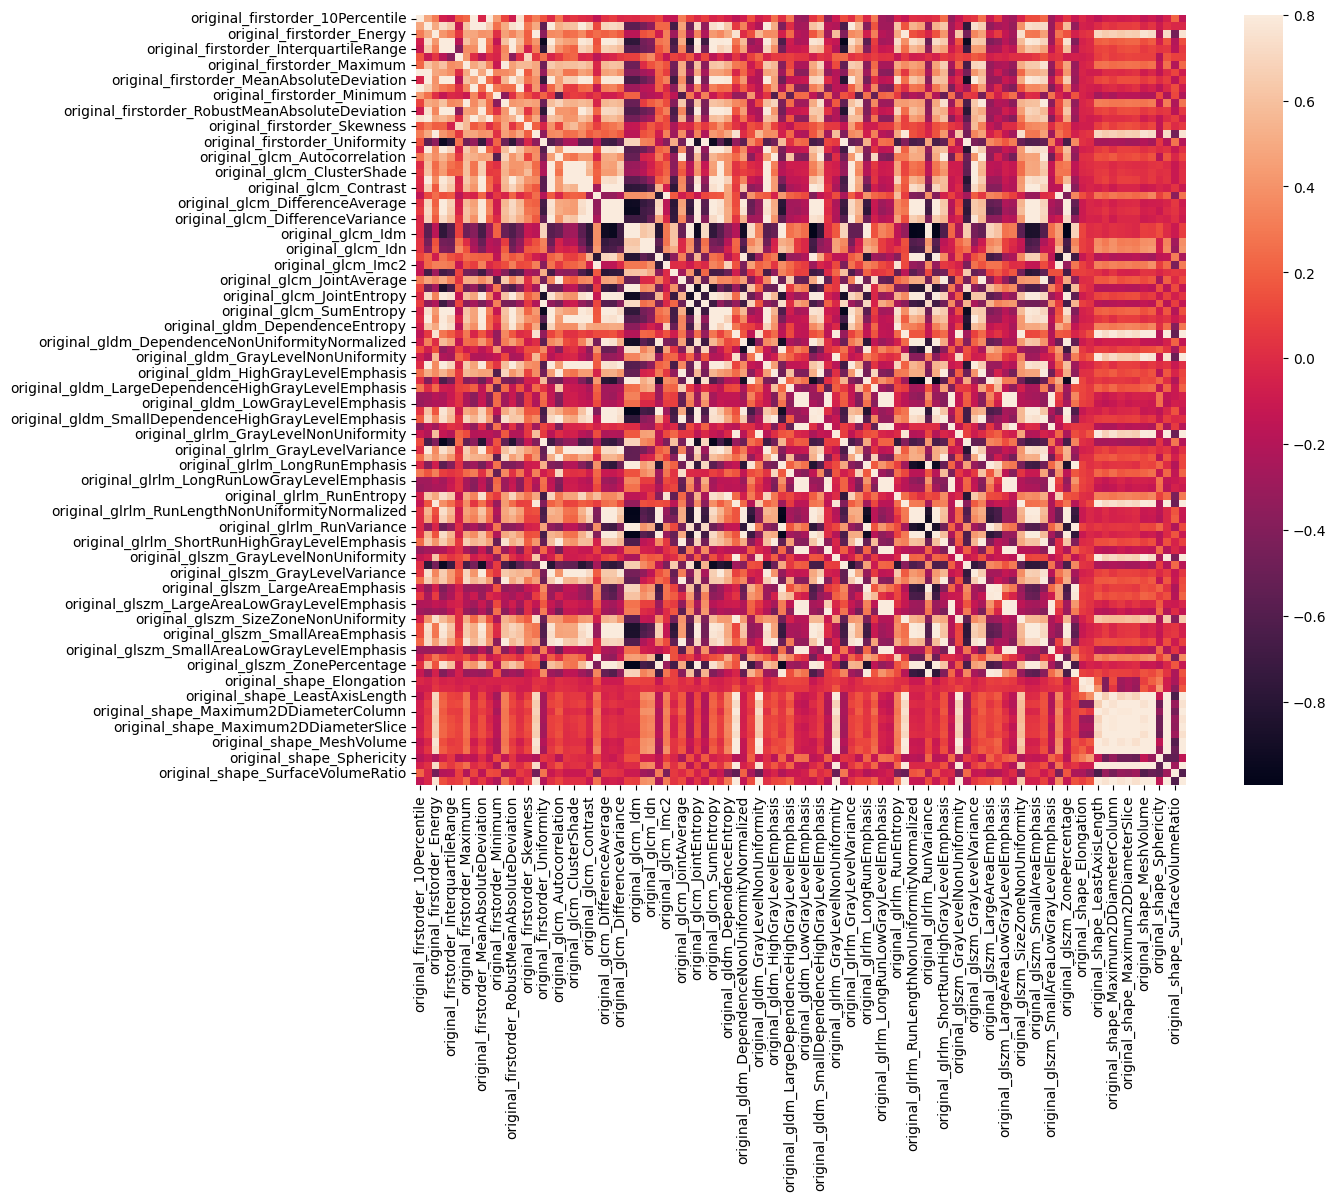

In [ ]:
import pandas as pd
import seaborn as sns

# filter one sequence type and a segmentation type (you can change the sequence type and segmentation type)
d = data[(data['sequence']=='t1ce')  & (data['segmentation']=='full')].iloc[:, 3:] # the full feature one is too big

# create the correlation matrix
corr = d.select_dtypes(include=['number']).corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

### Cluster the heatmap

Though useful, heatmaps tell a much better story if the features are clustered. Here we will take a smaller subset of the features and cluster them.

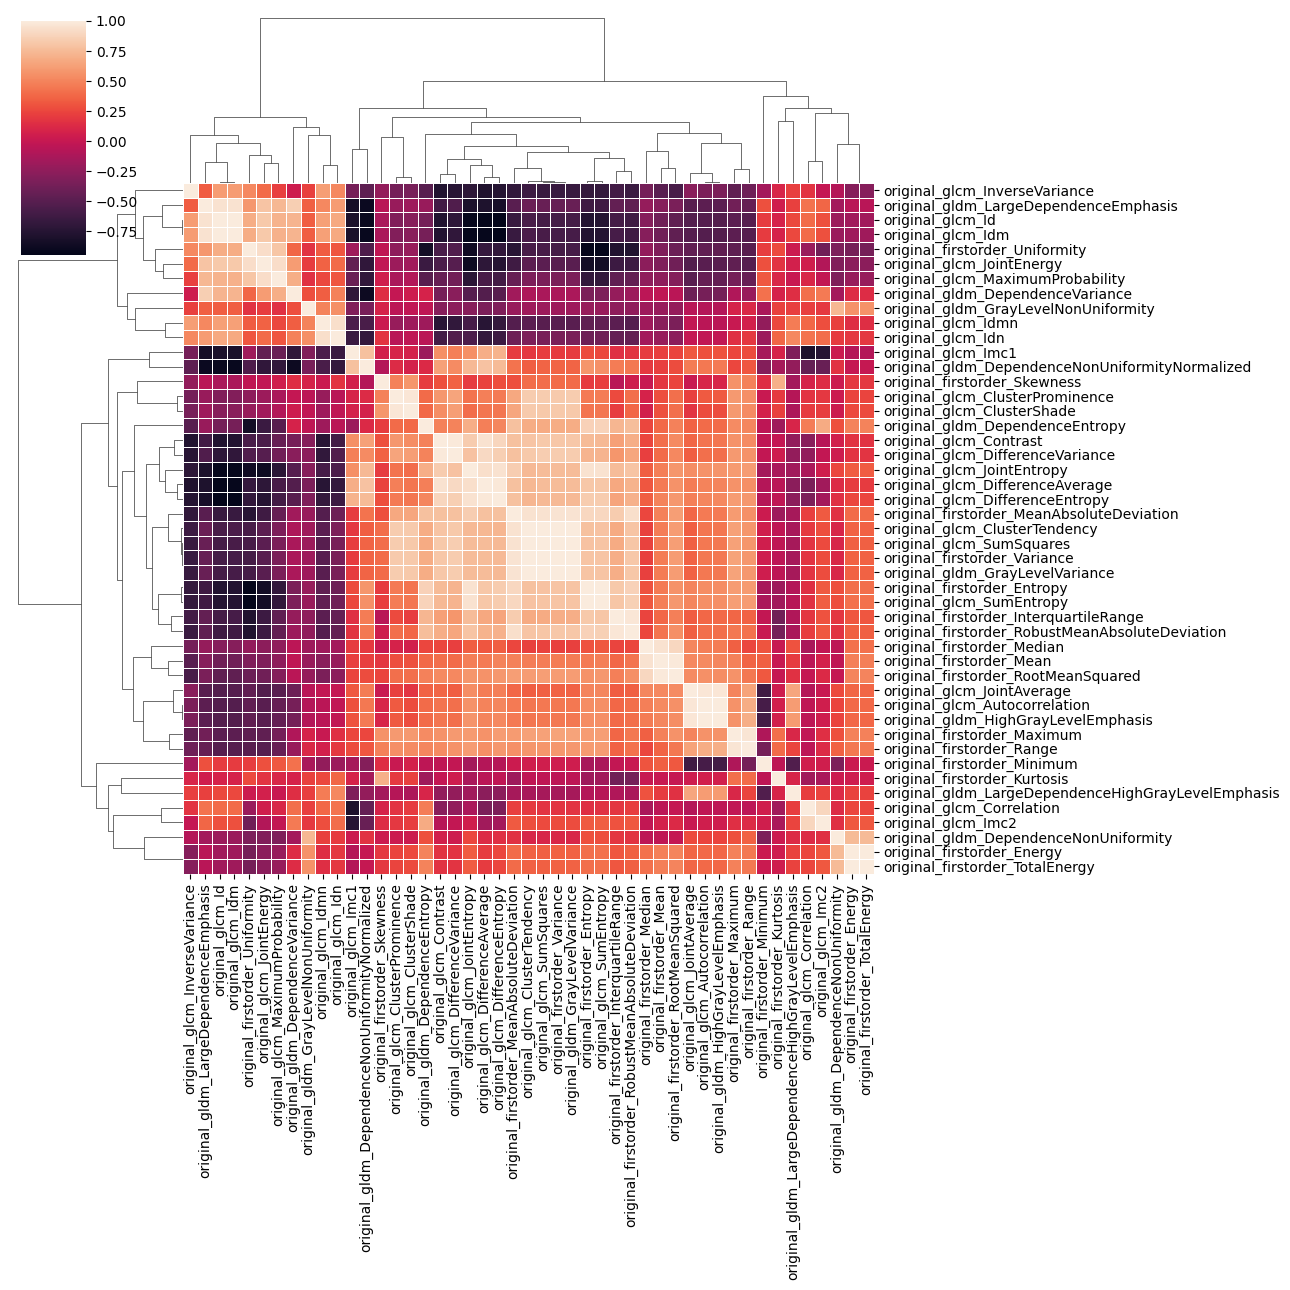

In [ ]:
# Choose a subset of features for clustering
dd = d.iloc[:,3:50]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()

### Solution 5: Interpretation

In this dendrogram, there are 2 major groups, and many smaller groupings.